# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import pandas as pd
import os
from glob import glob
from sklearn import preprocessing

# Chemin vers le fichier CSV contenant les données de catégories
csv_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_champ.csv'

# Chargement du DataFrame qui contient les informations des produits, y compris 'product_category_tree'
df_categories = pd.read_csv(csv_path)

# Fonction pour extraire la première catégorie de 'product_category_tree'
def get_first_category(category_tree):
    if category_tree.startswith('["'):
        categories = category_tree[2:-2].split(' >> ')
        if categories:
            return categories[0]
    return None

# Appliquer la fonction pour créer une nouvelle colonne 'first_category'
df_categories['first_category'] = df_categories['product_category_tree'].apply(get_first_category)

# Chemin vers le dossier des images
images_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images/'
images_path_test = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images2/'

# Récupération des chemins des images
data_path = glob(os.path.join(images_path, '*.jpg'))
data_path_test = glob(os.path.join(images_path_test, '*.jpg'))

# Création d'un DataFrame pour les chemins des images avec leur uniq_id
df_images = pd.DataFrame({
    'image_path': data_path,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})
df_images_test = pd.DataFrame({
    'image_path': data_path_test,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path_test]
})
# Fonction pour obtenir la catégorie à partir de l'identifiant unique
def photo_class(uniq_id):
    category = df_categories.loc[df_categories['uniq_id'] == uniq_id, 'first_category'].values
    if category.size > 0:
        return category[0]
    return "no_name"

# Liste des catégories valides
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

# Associer les catégories aux images
df_images['label_name'] = df_images['uniq_id'].apply(photo_class)
df_images_test['label_name'] = df_images_test['uniq_id'].apply(photo_class)

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(df_images['label_name'])
df_images['label'] = le.transform(df_images['label_name'])
le.fit(df_images_test['label_name'])
df_images_test['label'] = le.transform(df_images_test['label_name'])

# Vérification des données finales
print(df_images.head())
print(df_images_test.head())
# Maintenant, df_images contient le chemin de chaque image, son uniq_id, le nom de la catégorie, et la catégorie encodée.
# Ce DataFrame est prêt pour tout traitement d'image supplémentaire ou pour être utilisé pour l'entraînement de modèles.


                                          image_path  \
0  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
1  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
2  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
3  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
4  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   

                            uniq_id                label_name  label  
0  009099b1f6e1e8f893ec29a7023153c4                   Watches      6  
1  0096e89cc25a8b96fb9808716406fe94          Kitchen & Dining      5  
2  00cbbc837d340fa163d11e169fbdb952           Home Furnishing      4  
3  00d84a518e0550612fcfcba3b02b6255  Beauty and Personal Care      1  
4  00e966a5049a262cfc72e6bbf68b80e7                 Computers      2  
Empty DataFrame
Columns: [image_path, uniq_id, label_name, label]
Index: []


In [3]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]==name]
    return list_image_name

list_BC=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Baby Care"]
list_BPC=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Beauty and Personal Care"]
list_Computers=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Computers"]
list_HDFN=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Home Decor & Festive Needs"]
list_HF=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Home Furnishing"]
list_KD=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Kitchen & Dining"]
list_Watches=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Watches"]
list_Food=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="food"]


# Etape 2 : classification supervisée
2 approches sont présentées :
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

# VIT

## Création du modèle de classification

In [4]:
import torch
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),              # Redimensionner l'image pour être légèrement plus grande que la taille cible
    transforms.CenterCrop(224),          # Découper au centre pour obtenir la dimension finale
    transforms.ToTensor(),               # Convertir en tensor PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliser avec les moyennes et écarts-types d'ImageNet
])


c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import timm
import torch.nn as nn

# Charger un modèle ViT pré-entraîné
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Remplacer la dernière couche pour le nombre de classes spécifique à votre tâche
model.head = nn.Linear(model.head.in_features, 3)  # Remplacer 'nombre_de_classes' par le nombre de vos classes


## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [6]:
import pandas as pd
import os
from glob import glob
from sklearn import preprocessing

# Chemin vers le fichier CSV contenant les données de catégories
csv_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_Champ.csv'

# Chargement du DataFrame qui contient les informations des produits, y compris 'product_category_tree'
df_categories = pd.read_csv(csv_path)

# Fonction pour extraire la première catégorie de 'product_category_tree'
def get_first_category(category_tree):
    if category_tree.startswith('["'):
        categories = category_tree[2:-2].split(' >> ')
        if categories:
            return categories[0]
    return None

# Appliquer la fonction pour créer une nouvelle colonne 'first_category'
df_categories['first_category'] = df_categories['product_category_tree'].apply(get_first_category)

# Chemin vers le dossier des images
images_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images2/'
images_path_test = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images3/'

# Récupération des chemins des images
data_path = glob(os.path.join(images_path, '*.jpg'))
data_path_test = glob(os.path.join(images_path_test, '*.jpg'))

# Création d'un DataFrame pour les chemins des images avec leur uniq_id
df_images = pd.DataFrame({
    'image_path': data_path,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})
df_images_test = pd.DataFrame({
    'image_path': data_path_test,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})
# Fonction pour obtenir la catégorie à partir de l'identifiant unique
def photo_class(uniq_id):
    category = df_categories.loc[df_categories['uniq_id'] == uniq_id, 'first_category'].values
    if category.size > 0:
        return category[0]
    return "no_name"

# Liste des catégories valides
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

# Associer les catégories aux images
df_images['label_name'] = df_images['uniq_id'].apply(photo_class)
df_images_test['label_name'] = df_images_test['uniq_id'].apply(photo_class)

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(df_images['label_name'])
df_images['label'] = le.transform(df_images['label_name'])
le.fit(df_images_test['label_name'])
df_images_test['label'] = le.transform(df_images_test['label_name'])

# Vérification des données finales
print(df_images.head())
print(df_images_test.head())
# Maintenant, df_images contient le chemin de chaque image, son uniq_id, le nom de la catégorie, et la catégorie encodée.
# Ce DataFrame est prêt pour tout traitement d'image supplémentaire ou pour être utilisé pour l'entraînement de modèles.


Empty DataFrame
Columns: [image_path, uniq_id, label_name, label]
Index: []
Empty DataFrame
Columns: [image_path, uniq_id, label_name, label]
Index: []


In [7]:
import timm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms




In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Transformations pour l'entraînement et la validation sans augmentation
basic_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation pour pré-entraînement sur ImageNet
])

# Chemin vers vos dossiers de données
train_data_path = images_path
val_data_path = images_path_test

# Création des datasets avec les mêmes transformations pour le train et le val
train_dataset = ImageFolder(root=train_data_path, transform=basic_transforms)
val_dataset = ImageFolder(root=val_data_path, transform=basic_transforms)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)


In [10]:
# Définir la taille du batch
batch_size = 8

# Créer les DataLoaders pour le training et la validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader.dataset))
        train_accuracy.append(100 * correct / total)

        # Validation loss
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracy.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}')
        
    return train_losses, val_losses, train_accuracy, val_accuracy


In [12]:
try:
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)
    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
except Exception as e:
    print(f"Une erreur est survenue : {e}")


c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1, Train Loss: 1.1938, Train Acc: 66.13, Val Loss: 0.8444, Val Acc: 71.25
Epoch 2, Train Loss: 0.8511, Train Acc: 71.25, Val Loss: 0.8227, Val Acc: 71.25
Epoch 3, Train Loss: 0.8203, Train Acc: 71.25, Val Loss: 0.7989, Val Acc: 71.25
Epoch 4, Train Loss: 0.8226, Train Acc: 71.25, Val Loss: 0.8239, Val Acc: 71.25
Epoch 5, Train Loss: 0.8163, Train Acc: 71.25, Val Loss: 0.8159, Val Acc: 71.25
Epoch 6, Train Loss: 0.8183, Train Acc: 71.25, Val Loss: 0.7991, Val Acc: 71.25
Epoch 7, Train Loss: 0.8111, Train Acc: 71.25, Val Loss: 0.8029, Val Acc: 71.25
Epoch 8, Train Loss: 0.8069, Train Acc: 71.25, Val Loss: 0.7943, Val Acc: 71.25
Epoch 9, Train Loss: 0.8408, Train Acc: 70.02, Val Loss: 0.8799, Val Acc: 71.25
Epoch 10, Train Loss: 0.8180, Train Acc: 71.25, Val Loss: 0.7990, Val Acc: 71.25


Epoch 1, Train Loss: 0.8077, Train Acc: 71.25, Val Loss: 0.8059, Val Acc: 71.25
Epoch 2, Train Loss: 0.8087, Train Acc: 71.25, Val Loss: 0.7994, Val Acc: 71.25
Epoch 3, Train Loss: 0.8072, Train Acc: 71.25, Val Loss: 0.8201, Val Acc: 71.25
Epoch 4, Train Loss: 0.8150, Train Acc: 71.25, Val Loss: 0.8066, Val Acc: 71.25
Epoch 5, Train Loss: 0.8134, Train Acc: 71.25, Val Loss: 0.7984, Val Acc: 71.25
Epoch 6, Train Loss: 0.8211, Train Acc: 71.06, Val Loss: 0.8001, Val Acc: 71.25
Epoch 7, Train Loss: 0.8119, Train Acc: 71.25, Val Loss: 0.7996, Val Acc: 71.25
Epoch 8, Train Loss: 0.8112, Train Acc: 71.25, Val Loss: 0.8032, Val Acc: 71.25
Epoch 9, Train Loss: 0.8097, Train Acc: 71.25, Val Loss: 0.7983, Val Acc: 71.25
Epoch 10, Train Loss: 0.8134, Train Acc: 71.25, Val Loss: 0.8051, Val Acc: 71.25


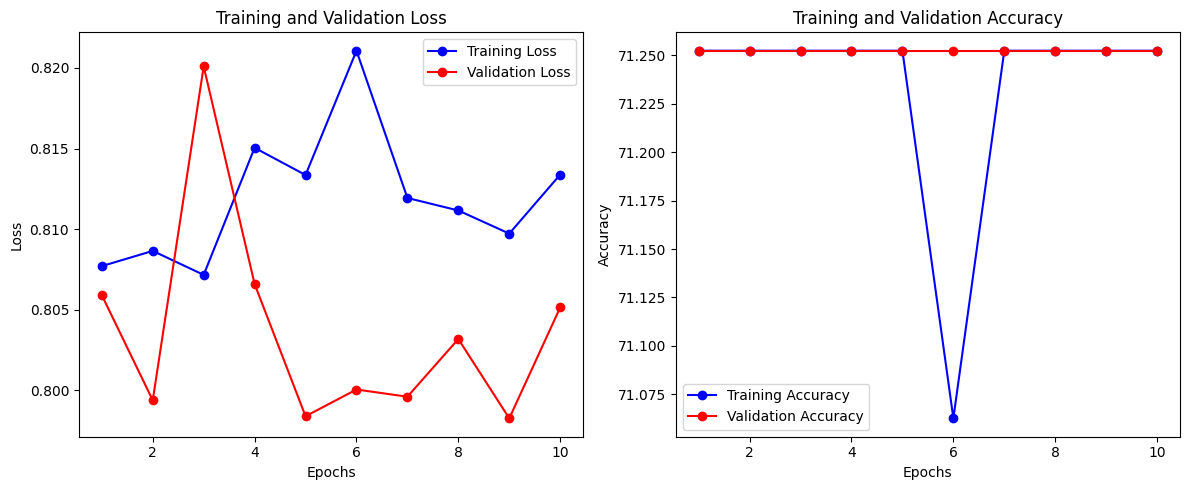

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Utilisez cette fonction après votre entraînement pour afficher les graphiques
train_losses, val_losses, train_accuracy, val_accuracy = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)


## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [15]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Recadrage aléatoire de l'image et redimensionnement à 224x224
    transforms.RandomHorizontalFlip(),  # Inversion horizontale aléatoire
    transforms.RandomRotation(15),  # Rotation aléatoire dans une plage de -15 à 15 degrés
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Modification aléatoire de la luminosité, du contraste, de la saturation et de la teinte
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation pour pré-entraînement sur ImageNet
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [16]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Chemin vers vos dossiers de données
train_data_path = images_path
val_data_path = images_path_test

# Création des datasets
train_dataset = ImageFolder(root=train_data_path, transform=train_transforms)
val_dataset = ImageFolder(root=val_data_path, transform=val_transforms)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)


In [18]:
# Définir la taille du batch
batch_size = 8

# Créer les DataLoaders pour le training et la validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [19]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader.dataset))
        train_accuracy.append(100 * correct / total)

        # Validation loss
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracy.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}')
        
    return train_losses, val_losses, train_accuracy, val_accuracy


Epoch 1, Train Loss: 0.8170, Train Acc: 71.25, Val Loss: 0.8183, Val Acc: 71.25
Epoch 2, Train Loss: 0.8121, Train Acc: 71.25, Val Loss: 0.7990, Val Acc: 71.25
Epoch 3, Train Loss: 0.8141, Train Acc: 71.25, Val Loss: 0.8282, Val Acc: 71.25
Epoch 4, Train Loss: 0.8491, Train Acc: 70.49, Val Loss: 0.8745, Val Acc: 65.09
Epoch 5, Train Loss: 0.8139, Train Acc: 71.25, Val Loss: 0.7988, Val Acc: 71.25
Epoch 6, Train Loss: 0.8064, Train Acc: 71.25, Val Loss: 0.8000, Val Acc: 71.25
Epoch 7, Train Loss: 0.8097, Train Acc: 71.25, Val Loss: 0.8038, Val Acc: 71.25
Epoch 8, Train Loss: 0.8125, Train Acc: 71.25, Val Loss: 0.8100, Val Acc: 71.25
Epoch 9, Train Loss: 0.8171, Train Acc: 71.25, Val Loss: 0.8057, Val Acc: 71.25
Epoch 10, Train Loss: 0.8080, Train Acc: 71.25, Val Loss: 0.8014, Val Acc: 71.25


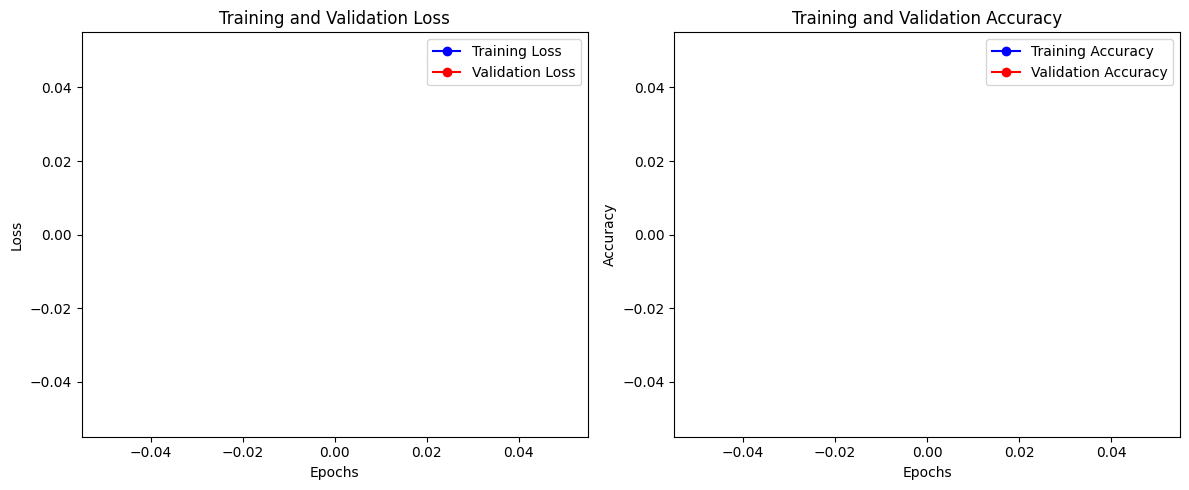

In [20]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

try:
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)
    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
except Exception as e:
    print(f"Une erreur est survenue : {e}")
    
# Utilisez cette fonction après votre entraînement pour afficher les graphiques
train_losses, val_losses, train_accuracy, val_accuracy = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=4)
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

# VGG16

## Création du modèle de classification

In [ ]:
def process_image(file_path):
    # Lire l'image en mode couleur, réduction de bruit et amélioration du contraste
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # Redimensionnement pour VGG16
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)  # Réduction de bruit
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final_img

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche nouvelle par Dataset sans data augmentation


In [ ]:
import pandas as pd
import os
from glob import glob
from sklearn import preprocessing

# Chemin vers le fichier CSV contenant les données de catégories
csv_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_Champ.csv'

# Chargement du DataFrame qui contient les informations des produits, y compris 'product_category_tree'
df_categories = pd.read_csv(csv_path)

# Fonction pour extraire la première catégorie de 'product_category_tree'
def get_first_category(category_tree):
    if category_tree.startswith('["'):
        categories = category_tree[2:-2].split(' >> ')
        if categories:
            return categories[0]
    return None

# Appliquer la fonction pour créer une nouvelle colonne 'first_category'
df_categories['first_category'] = df_categories['product_category_tree'].apply(get_first_category)

# Chemin vers le dossier des images
images_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images2/'
images_path_test = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images3/'

# Récupération des chemins des images
data_path = glob(os.path.join(images_path, '*.jpg'))
data_path_test = glob(os.path.join(images_path_test, '*.jpg'))

# Création d'un DataFrame pour les chemins des images avec leur uniq_id
df_images = pd.DataFrame({
    'image_path': data_path,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})
df_images_test = pd.DataFrame({
    'image_path': data_path_test,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})
# Fonction pour obtenir la catégorie à partir de l'identifiant unique
def photo_class(uniq_id):
    category = df_categories.loc[df_categories['uniq_id'] == uniq_id, 'first_category'].values
    if category.size > 0:
        return category[0]
    return "no_name"

# Liste des catégories valides
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

# Associer les catégories aux images
df_images['label_name'] = df_images['uniq_id'].apply(photo_class)
df_images_test['label_name'] = df_images_test['uniq_id'].apply(photo_class)

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(df_images['label_name'])
df_images['label'] = le.transform(df_images['label_name'])
le.fit(df_images_test['label_name'])
df_images_test['label'] = le.transform(df_images_test['label_name'])

# Vérification des données finales
print(df_images.head())
print(df_images_test.head())
# Maintenant, df_images contient le chemin de chaque image, son uniq_id, le nom de la catégorie, et la catégorie encodée.
# Ce DataFrame est prêt pour tout traitement d'image supplémentaire ou pour être utilisé pour l'entraînement de modèles.


In [ ]:
batch_size = 32

def dataset_fct(images_path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    images_path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(images_path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(images_path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(images_path_test, validation_split=0, data_type=None)

In [ ]:
def create_model_fct2() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct2()

# Création du callback
model3_save_path = "./model3_best_weights.keras"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle


In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(images_path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(images_path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(images_path_test, validation_split=0, data_type=None)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [ ]:
def create_model_fct3() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.4),
                Dense(3, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct3()

# Création du callback
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks_list = [checkpoint, es]


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()